# RFM Analysis

## Load Data from SQL

In [1]:
from sqlalchemy import create_engine, text
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
import pandas as pd

# Database configuration
DB_USERNAME = 'postgres'
DB_PASSWORD = '1234'
DB_HOST = 'localhost'
DB_PORT = '5432'  # Default port for PostgreSQL
DB_NAME = 'brazilian_ecommerce_db'

# Create an engine to connect to PostgreSQL
engine = create_engine(f'postgresql+psycopg2://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')

customers = pd.read_sql('SELECT * FROM customers', engine).drop('id', axis = 1)
orders = pd.read_sql('SELECT * FROM orders', engine).drop('id', axis = 1)
payments = pd.read_sql('SELECT * FROM payments', engine).drop('id', axis = 1)

engine.dispose()

## 1.Recency

In [2]:
import pandas as pd
import numpy as np

# Merging customer and order data
recency_table = customers.merge(orders, on="customer_id")
recency_table = recency_table.groupby('customer_unique_id').agg({'order_purchase_timestamp': 'max'}).reset_index()

# Converting to datetime dtype
recency_table['order_purchase_timestamp'] = pd.to_datetime(recency_table['order_purchase_timestamp'])

# Calculate the current day
current_day = pd.to_datetime(max(orders['order_purchase_timestamp']))

# Calculate the days between
recency_table['recency'] = (current_day - recency_table['order_purchase_timestamp']).dt.days

# Define the scoring function
def scoring(x):
    # Calculate quantiles in one step
    quantiles = np.quantile(x, [0.2, 0.4, 0.6, 0.8])
    
    # Function to assign score based on quantile values
    def labeling(value):
        if value <= quantiles[0]: return 1
        elif value <= quantiles[1]: return 2
        elif value <= quantiles[2]: return 3
        elif value <= quantiles[3]: return 4
        else: return 5
    
    return x.apply(labeling)

# Apply the scoring function
recency_table['recency_score'] = scoring(recency_table['recency'])

In [3]:
recency_table.drop('order_purchase_timestamp',axis = 1,inplace = True)

In [4]:
recency_table

,customer_unique_id,recency,recency_score
0,0000366f3b9a7992bf8c76cfdf3221e2,160,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,2
2,0000f46a3911fa3c0805444483337064,585,5
3,0000f6ccb0745a6a4b88665a16c9f078,369,4
4,0004aac84e0df4da2b147fca70cf8255,336,4
...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,495,5
96092,fffea47cd6d3cc0a88bd621562a9d061,310,3
96093,ffff371b4d645b6ecea244b27531430a,617,5
96094,ffff5962728ec6157033ef9805bacc48,168,2


## 2.Frequency

In [5]:
# merging df
frequency_table = customers.merge(orders, on="customer_id")
# getting interested information
frequency_table = frequency_table.groupby('customer_unique_id').agg({
    "order_purchase_timestamp": ['min', 'max'],
    "order_id": 'count'
}).reset_index()
# change columns
frequency_table.columns = ['customer_unique_id', 'min', 'max', 'frequency']
# change data type
frequency_table['max'] = pd.to_datetime(frequency_table['max'])
frequency_table['min'] = pd.to_datetime(frequency_table['min'])
# days between first and last day of purchase 
frequency_table['days_between'] = (frequency_table['max'] - frequency_table['min']).apply(lambda x: int(str(x).split()[0]))

In [6]:
frequency_table

,customer_unique_id,min,max,frequency,days_between
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,2018-05-10 10:56:27,1,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,2018-05-07 11:11:27,1,0
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2017-03-10 21:05:03,1,0
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2017-10-12 20:29:41,1,0
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,2017-11-14 19:45:42,1,0
...,...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,2017-06-08 21:00:36,1,0
96092,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,2017-12-10 20:07:56,1,0
96093,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,2017-02-07 15:49:16,1,0
96094,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,2018-05-02 15:17:41,1,0


C:\Users\Acer\AppData\Local\Temp\ipykernel_9728\495840601.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='Count', data=data, palette=['green', 'red'])
C:\Users\Acer\AppData\Local\Temp\ipykernel_9728\495840601.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


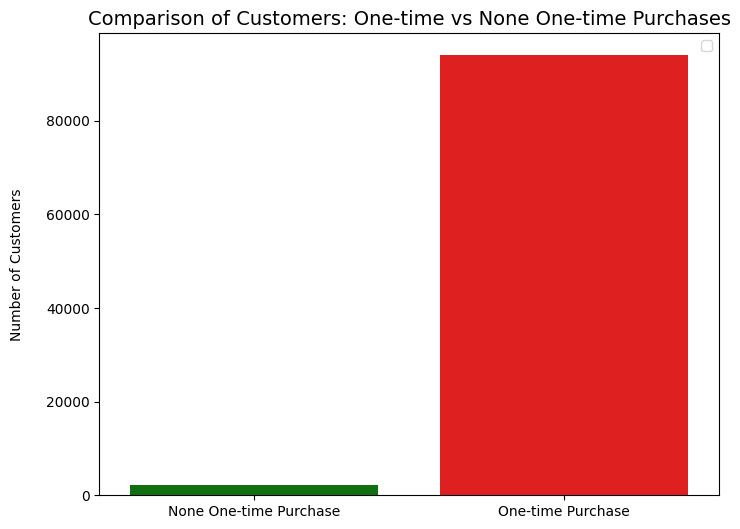

In [7]:
import seaborn as sns 
import matplotlib.pyplot as plt
# Split the frequency table into two parts
customers_non_one_time = frequency_table[frequency_table["days_between"] > 0]
customers_one_time = frequency_table[frequency_table["days_between"] == 0]

# Create a new DataFrame to represent the counts of each group
data = pd.DataFrame({
    'Category': ['None One-time Purchase', 'One-time Purchase'],
    'Count': [len(customers_non_one_time), len(customers_one_time)]
})

# Plotting the bar chart with custom colors
plt.figure(figsize=(8, 6))
sns.barplot(x='Category', y='Count', data=data, palette=['green', 'red'])

# Add a title and labels
plt.title('Comparison of Customers: One-time vs None One-time Purchases', fontsize=14)
plt.ylabel('Number of Customers\n')
plt.xlabel('')
plt.legend()

# Display the plot
plt.show()

In [8]:
# get rid of one-time-purchase customer
frequency_table = frequency_table[frequency_table['days_between']>0]
# calculate purchase_rate
frequency_table['purchase_rate'] = frequency_table['frequency'] / frequency_table['days_between']
# score the purchase_rate
frequency_table['frequency_score'] = scoring(frequency_table['purchase_rate'])
frequency_table.drop(columns = ['min', 'max', 'days_between', 'purchase_rate'],inplace = True)

C:\Users\Acer\AppData\Local\Temp\ipykernel_9728\56801274.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frequency_table['purchase_rate'] = frequency_table['frequency'] / frequency_table['days_between']
C:\Users\Acer\AppData\Local\Temp\ipykernel_9728\56801274.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frequency_table['frequency_score'] = scoring(frequency_table['purchase_rate'])
C:\Users\Acer\AppData\Local\Temp\ipykernel_9728\56801274.py:7: SettingWithCopyWarning: 
A value is trying to be set o

In [9]:
frequency_table

,customer_unique_id,frequency,frequency_score
33,00172711b30d52eea8b313a7f2cced02,2,5
106,004288347e5e88a27ded2bb23747066c,2,2
124,004b45ec5c64187465168251cd1c9c2f,2,1
144,0058f300f57d7b93c477a131a59b36c3,2,4
249,00a39521eb40f7012db50455bf083460,2,5
...,...,...,...
95709,ff03923ad1eb9e32304deb7f9b2a45c9,2,4
95757,ff22e30958c13ffe219db7d711e8f564,2,5
95784,ff36be26206fffe1eb37afd54c70e18b,3,5
95916,ff8892f7c26aa0446da53d01b18df463,2,2


## 3.Monetary

In [10]:
monetary_table = payments.merge(orders, on="order_id").merge(customers, on="customer_id")
monetary_table = monetary_table.groupby('customer_unique_id').agg({'payment_value':'sum'}).reset_index()
monetary_table['monetary_score'] = scoring(monetary_table['payment_value'])
monetary_table.columns = ['customer_unique_id', 'monetary', 'monetary_score']
monetary_table.head()

,customer_unique_id,monetary,monetary_score
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,4
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1
2,0000f46a3911fa3c0805444483337064,86.22,2
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,1
4,0004aac84e0df4da2b147fca70cf8255,196.89,4


## 4.Combine All Together

In [11]:
final_table = recency_table.merge(monetary_table, on = 'customer_unique_id').merge(frequency_table, on='customer_unique_id')
clusters_table = final_table[['customer_unique_id', "recency", "frequency","monetary"]]
trad_table = final_table[['customer_unique_id', "recency_score", "frequency_score","monetary_score"]]
trad_table['frequency_monetary_score'] = scoring(trad_table['frequency_score'] + trad_table['monetary_score'])
trad_table = trad_table[['customer_unique_id', 'recency_score', 'frequency_monetary_score']]

C:\Users\Acer\AppData\Local\Temp\ipykernel_9728\746439085.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trad_table['frequency_monetary_score'] = scoring(trad_table['frequency_score'] + trad_table['monetary_score'])


In [12]:
trad_table.shape

(2122, 3)

In [13]:
segment_dict = {

# hibernating
(1,1):"hibernating",
(1,2):"hibernating",
(2,1):"hibernating",
(2,2):"hibernating",
    
# about to sleep
(3,1):"about to sleep",
(3,2):"about to sleep",
    
# promising
(4,1):"promising",
    
# new customer
(5,1):"new customer",
    
# potential customers
(4,2):"potential",
(4,3):"potential",
(5,2):"potential",
(5,3):"potential",
    
# need attion
(3,3):"need attion",
    
# at risk
(1,3):"at risk",
(1,4):"at risk",
(2,3):"at risk",
(2,4):"at risk",
    
# do not lose
(1,5):"do not lose",
(2,5):"do not lose",
    
# loyal customer
(3,4):"loyal",
(3,5):"loyal",
(4,4):"loyal",
(4,5):"loyal",

# champions
(5,4):"champions",
(5,5):"champions"}

trad_table['segment'] = trad_table.apply(lambda x:
                  segment_dict[(x['recency_score'],x['frequency_monetary_score'])]
                  , axis = 1
                  )

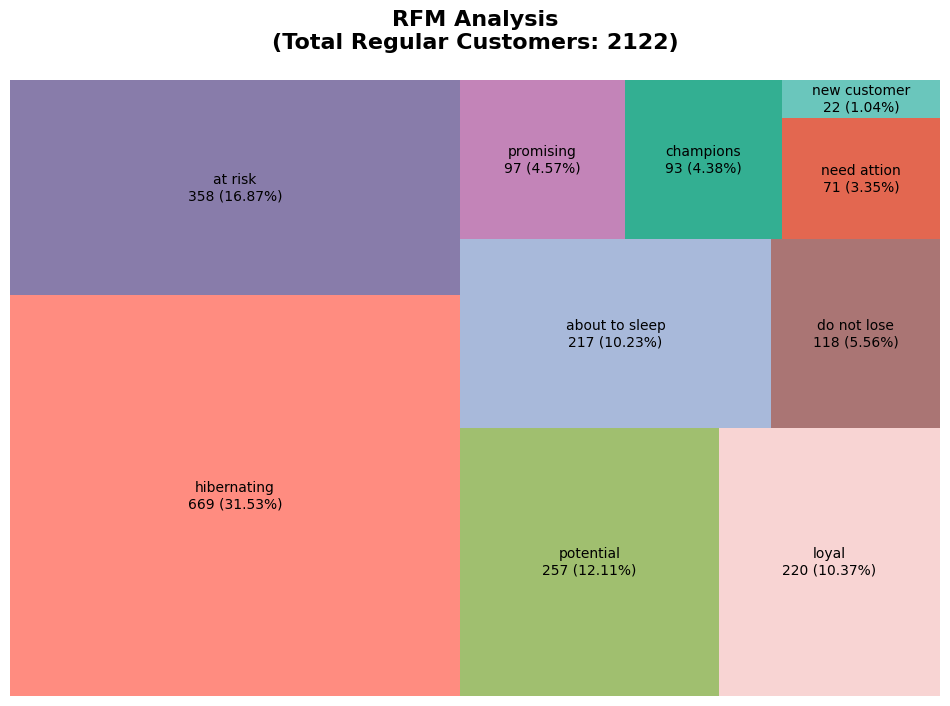

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import squarify

# Assuming you already have the 'trad_table' and 'segment_dict'

# Step 1: Assign customer segments based on `recency_score` and `frequency_monetary_score`
trad_table['segment'] = trad_table.apply(lambda x:
                  segment_dict[(x['recency_score'], x['frequency_monetary_score'])], axis=1)

# Step 2: Count the number of customers in each segment
segment_counts = trad_table['segment'].value_counts().reset_index()
segment_counts.columns = ['segment', 'count']

# Step 3: Create a new column with percentages for better visualization
total_customers = segment_counts['count'].sum()
segment_counts['percentage'] = round((segment_counts['count'] / total_customers) * 100, 2)

# Step 4: Prepare labels and values for the treemap
labels = [f'{row["segment"]}\n{row["count"]} ({row["percentage"]}%)' for index, row in segment_counts.iterrows()]
sizes = segment_counts['count'].values

# Step 5: Define a custom color palette (distinct colors)
colors = ['#FF6F61', '#6B5B95', '#88B04B', '#F7CAC9', '#92A8D1', 
          '#955251', '#B565A7', '#009B77', '#DD4124', '#45B8AC', 
          '#EFC050', '#5B5EA6', '#9B2335', '#DFCFBE', '#BC243C']  # Add more if needed

# Step 6: Create the Treemap using squarify
plt.figure(figsize=(12, 8))  # You can adjust the size here

squarify.plot(
    sizes=sizes,
    label=labels,
    color=colors[:len(segment_counts)],  # Apply custom colors
    alpha=0.8
)

plt.title(f'RFM Analysis\n(Total Regular Customers: {total_customers})\n', fontsize=16,fontweight = 'bold')
plt.axis('off')  # Turn off axis

# Show the treemap
plt.show()